# CWRU Experiments
## Imports

In [1]:
import pandas as pd
import numpy as np

import lib.transformers as tfs
from sklearn.pipeline import Pipeline

from lib.models import Ganomaly1d, Ganomaly2d, GanomalyFE, GanomalyNet
from lib.visualization import GANomalyBoard, rename_tensorboard_key

from skorch.callbacks import PassthroughScoring, ProgressBar
import torch

from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

from keras.datasets import mnist
import tensorflow

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from lib.others import create_dataset

from lib.others import build_model
from lib.visualization import lineplot_comparison

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
cwruData0 = pd.read_parquet('data/cwru0.parquet')
cwruData1 = pd.read_parquet('data/cwru1.parquet')

cwruData = pd.concat([cwruData0, cwruData1])

## Settings

In [3]:
# torch.manual_seed(0)
# torch.cuda.manual_seed(0)
# np.random.seed(0)

## Creating Datasets

In [4]:
normal_features, normal_labels = create_dataset(cwruData, feature_columns = ['fanEndData', 'driveEndData'], label_columns = ['condition', 'faultDiameter', 'motorLoad', 'relativeFaultPosition', 'faultyBearingPosition'], condition = ['Normal Baseline'], sampleRate = [12000])
normal_features_train, normal_features_test, normal_labels_train, normal_labels_test = train_test_split(normal_features, normal_labels, train_size = 400, test_size= 451, random_state = 0)

ball_features, ball_labels = create_dataset(cwruData, feature_columns = ['fanEndData'], label_columns = ['condition', 'faultDiameter', 'motorLoad', 'relativeFaultPosition', 'faultyBearingPosition'], condition = ['Ball Fault'], sampleRate = [12000])
inner_features, inner_labels = create_dataset(cwruData, feature_columns = ['fanEndData'], label_columns = ['condition', 'faultDiameter', 'motorLoad', 'relativeFaultPosition', 'faultyBearingPosition'], condition = ['Inner Race Fault'], sampleRate = [12000])
outer_features, outer_labels = create_dataset(cwruData, feature_columns = ['fanEndData'], label_columns = ['condition', 'faultDiameter', 'motorLoad', 'relativeFaultPosition', 'faultyBearingPosition'], condition = ['Outer Race Fault'], sampleRate = [12000])


labels_test = pd.concat([ball_labels, inner_labels, outer_labels, normal_labels_test])
features_test = pd.concat([ball_features, inner_features, outer_features, normal_features_test])

normal_features_test = np.array(normal_features_test.to_list())
normal_features_train = np.array(normal_features_train.to_list())

# GridSearchCV

In [5]:
search_parameters = {
    'Model__module__w_app': list(range(0, 31, 30)),
}

In [6]:
#ganomaly_gs = GridSearchCV(model_fft, search_parameters, refit=False, cv=2)

## Building and training the different Models

In [7]:
# model settings
n_z = 600
n_channels = 1
n_feature_maps = 32

fraud_weight = 1
appearant_weight = 1
latent_weight = 1
lambda_weight = 0.5

# training settings
device = torch.device("cuda:0") if torch.cuda.is_available() else 'cpu'
n_gpus = 0
workers = 2
batch_size = 16
max_epochs = 2
lr = 0.0001
beta1 = 0.5
beta2 = 0.999

# extra callbacks
callbacks = []

# run number
run = 1000
verbose = 1

### Time Series

In [8]:
gan_time_series =\
build_model(
    model = Ganomaly1d,
    
    # model parameters
    input_size = 3136, 
    n_z = n_z,
    n_channels = n_channels,
    n_fm_discriminator = n_feature_maps,  
    n_fm_generator = n_feature_maps,
    fraud_weight = fraud_weight,
    appearant_weight = appearant_weight, 
    latent_weight = latent_weight,
    lambda_weight = lambda_weight,
    
    # training parameters
    device = device,
    n_gpus = n_gpus,
    workers = workers,
    batch_size = batch_size,
    max_epochs = max_epochs, 
    lr = 0.0001,
    beta1 = 0.5,
    beta2 = 0.999, 
    
    # logging parameters
    suffix = 'timeseries' + str(run),
    plot_type = 'lineplot', 
    plot_shape = 3136, 
    plot_latent_shape =600, 
    n_samples = 4,
    
    # extra callbacks
    callbacks = callbacks,
    verbose = verbose
)

In [9]:
pipeline_time_series = \
Pipeline(steps=[
                ('scaler', tfs.ArrayMinMaxScaler()),
                ('reshaper', tfs.ArrayReshaper((1, 3136))),
                ('retyper', tfs.ArrayRetyper(np.float32)),
                ('model', gan_time_series)
               ])

In [10]:
pipeline_time_series.fit(normal_features_train);

  epoch    appearant_loss    discriminator_loss    fraud_loss    generator_loss    latent_loss    train_loss      dur
-------  ----------------  --------------------  ------------  ----------------  -------------  ------------  -------
      1            0.3970                0.4297        0.8076            1.7594         0.5548        2.1891  13.1557
      2            0.3018                0.1023        0.6396            1.1710         0.2296        1.2733  12.9976


Pipeline(steps=[('scaler',
                 <lib.transformers.ArrayMinMaxScaler object at 0x000002518C707D30>),
                ('reshaper',
                 <lib.transformers.ArrayReshaper object at 0x000002518C707D60>),
                ('retyper',
                 <lib.transformers.ArrayRetyper object at 0x000002518C707A60>),
                ('model',
                 <class 'lib.models.GanomalyNet'>[initialized](
  module_=Ganomaly1d(
    (discriminator_loss): BCELoss()
    (appearant_loss...
          (pyramid-relu-128): LeakyReLU(negative_slope=0.2, inplace=True)
          (pyramid-128-256-convt): Conv1d(128, 256, kernel_size=(16,), stride=(4,), bias=False)
          (pyramid-256-batchnorm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (pyramid-relu-256): LeakyReLU(negative_slope=0.2, inplace=True)
          (final-256-1-convt): Conv1d(256, 600, kernel_size=(9,), stride=(1,), bias=False)
        )
      )
    )
  ),
))])

### Stacked Time Series

In [11]:
gan_stacked_time_series =\
build_model(
    model = Ganomaly2d,
    
    # model parameters
    input_size = 56, 
    n_z = n_z,
    n_channels = n_channels,
    n_fm_discriminator = n_feature_maps,  
    n_fm_generator = n_feature_maps,
    fraud_weight = fraud_weight,
    appearant_weight = appearant_weight, 
    latent_weight = latent_weight,
    lambda_weight = lambda_weight,
    
    # training parameters
    device = device,
    n_gpus = n_gpus,
    workers = workers,
    batch_size = batch_size,
    max_epochs = max_epochs, 
    lr = 0.0001,
    beta1 = 0.5,
    beta2 = 0.999, 
    
    # logging parameters
    suffix = 'stacked_timeseries' + str(run), 
    plot_type = 'lineplot', 
    plot_shape = 3136, 
    plot_latent_shape =600, 
    n_samples = 4,
    
    # extra callbacks
    callbacks = callbacks,
    verbose = verbose
)

In [12]:
pipeline_stacked_time_series = \
Pipeline(steps=[
                ('reshaper', tfs.ArrayReshaper((1, 56, 56))),
                ('scaler', tfs.ArrayMinMaxScaler()),
                ('retyper', tfs.ArrayRetyper(np.float32)),
                ('model', gan_stacked_time_series)
               ])

In [13]:
pipeline_stacked_time_series.fit(normal_features_train);

  epoch    appearant_loss    discriminator_loss    fraud_loss    generator_loss    latent_loss    train_loss      dur
-------  ----------------  --------------------  ------------  ----------------  -------------  ------------  -------
      1            0.4667                0.2986        0.6954            1.4072         0.2451        1.7057  11.2971
      2            0.3466                0.0438        0.3704            0.7447         0.0276        0.7885  11.1869


Pipeline(steps=[('reshaper',
                 <lib.transformers.ArrayReshaper object at 0x000002518C76BAC0>),
                ('scaler',
                 <lib.transformers.ArrayMinMaxScaler object at 0x000002518E3D8BE0>),
                ('retyper',
                 <lib.transformers.ArrayRetyper object at 0x000002518E3D8C10>),
                ('model',
                 <class 'lib.models.GanomalyNet'>[initialized](
  module_=Ganomaly2d(
    (discriminator_loss): BCELoss()
    (appearant_loss...
          (pyramid-128-relu): LeakyReLU(negative_slope=0.2, inplace=True)
          (pyramid-128-256-conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (pyramid-256-batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (pyramid-256-relu): LeakyReLU(negative_slope=0.2, inplace=True)
          (final-256-1-conv): Conv2d(256, 600, kernel_size=(3, 3), stride=(1, 1), bias=False)
        )
      )
    )
  )

### Frequency Spectrum

In [14]:
gan_frequency_spectrum =\
build_model(
    model = Ganomaly1d,
    
    # model parameters
    input_size = 1568, 
    n_z = n_z,
    n_channels = n_channels,
    n_fm_discriminator = n_feature_maps,  
    n_fm_generator = n_feature_maps,
    fraud_weight = fraud_weight,
    appearant_weight = appearant_weight, 
    latent_weight = latent_weight,
    lambda_weight = lambda_weight,
    
    # training parameters
    device = device,
    n_gpus = n_gpus,
    workers = workers,
    batch_size = batch_size,
    max_epochs = max_epochs, 
    lr = lr,
    beta1 = beta1,
    beta2 = beta2, 
    
    # logging parameters
    suffix = 'frequency_spectrum' + str(run), 
    plot_type = 'lineplot', 
    plot_shape = 1568, 
    plot_latent_shape = 600, 
    n_samples = 4,
    
    # extra callbacks
    callbacks = callbacks,
    verbose = verbose
)

In [15]:
pipeline_frequency_spectrum = \
Pipeline(steps=[
                ('fourier_transform', tfs.ArrayFFT()),
                ('reshaper', tfs.ArrayReshaper((1, 1568))),
                ('scaler', tfs.ArrayMinMaxScaler()),
                ('retyper', tfs.ArrayRetyper(np.float32)),
                ('model', gan_frequency_spectrum)
               ])

In [16]:
pipeline_frequency_spectrum.fit(normal_features_train);

  epoch    appearant_loss    discriminator_loss    fraud_loss    generator_loss    latent_loss    train_loss     dur
-------  ----------------  --------------------  ------------  ----------------  -------------  ------------  ------
      1            0.0682                0.4131        0.9177            1.0658         0.0799        1.4789  6.4225
      2            0.0396                0.1293        0.9033            0.9560         0.0131        1.0853  6.1096


Pipeline(steps=[('fourier_transform',
                 <lib.transformers.ArrayFFT object at 0x000002518E418AF0>),
                ('reshaper',
                 <lib.transformers.ArrayReshaper object at 0x000002518E418B20>),
                ('scaler',
                 <lib.transformers.ArrayMinMaxScaler object at 0x000002518E418A90>),
                ('retyper',
                 <lib.transformers.ArrayRetyper object at 0x000002518E4182B0>),
                ('model',
                 <class 'lib.models.GanomalyNet'>[i...
          (pyramid-relu-64): LeakyReLU(negative_slope=0.2, inplace=True)
          (pyramid-64-128-convt): Conv1d(64, 128, kernel_size=(16,), stride=(4,), bias=False)
          (pyramid-128-batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (pyramid-relu-128): LeakyReLU(negative_slope=0.2, inplace=True)
          (final-128-1-convt): Conv1d(128, 600, kernel_size=(9,), stride=(1,), bias=False)
        )
      )
    )
  )

### Spectrogram

In [17]:
gan_spectrogram =\
build_model(
    model = Ganomaly2d,
    
    # model parameters
    input_size = 56, 
    n_z = n_z,
    n_channels = n_channels,
    n_fm_discriminator = n_feature_maps,  
    n_fm_generator = n_feature_maps,
    fraud_weight = fraud_weight,
    appearant_weight = appearant_weight, 
    latent_weight = latent_weight,
    lambda_weight = lambda_weight,
    
    # training parameters
    device = device,
    n_gpus = n_gpus,
    workers = workers,
    batch_size = batch_size,
    max_epochs = max_epochs, 
    lr = lr,
    beta1 = beta1,
    beta2 = beta2, 
    
    # logging parameters
    suffix = 'spectrograms' + str(run),
    plot_type = 'image', 
    plot_shape = 56, 
    plot_latent_shape =600, 
    n_samples = 36,

    # extra callbacks
    callbacks = callbacks,
    verbose = verbose
)

In [18]:
pipeline_spectrogram = \
Pipeline(steps=[
                ('stft_transform', tfs.ArraySTFT()),
                ('reshaper', tfs.ArrayReshaper((1, 56, 56))),
                ('scaler', tfs.ArrayMinMaxScaler()),
                ('retyper', tfs.ArrayRetyper(np.float32)),
                ('model', gan_spectrogram)
               ])

In [19]:
pipeline_spectrogram.fit(normal_features_train);

  epoch    appearant_loss    discriminator_loss    fraud_loss    generator_loss    latent_loss    train_loss      dur
-------  ----------------  --------------------  ------------  ----------------  -------------  ------------  -------
      1            0.1187                0.2679        0.7569            1.0437         0.1681        1.3115  11.3352
      2            0.0762                0.0422        0.5547            0.6536         0.0227        0.6958  12.2784


Pipeline(steps=[('stft_transform',
                 <lib.transformers.ArraySTFT object at 0x000002518E70D2B0>),
                ('reshaper',
                 <lib.transformers.ArrayReshaper object at 0x000002518E70D910>),
                ('scaler',
                 <lib.transformers.ArrayMinMaxScaler object at 0x000002518E70DA00>),
                ('retyper',
                 <lib.transformers.ArrayRetyper object at 0x000002518E70D6A0>),
                ('model',
                 <class 'lib.models.GanomalyNet'>[ini...
          (pyramid-128-relu): LeakyReLU(negative_slope=0.2, inplace=True)
          (pyramid-128-256-conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (pyramid-256-batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (pyramid-256-relu): LeakyReLU(negative_slope=0.2, inplace=True)
          (final-256-1-conv): Conv2d(256, 600, kernel_size=(3, 3), stride=(1, 1), bias=False)
   

### Feature Extraction

In [20]:
gan_feature_extraction =\
build_model(
    model = GanomalyFE,
    
    # model parameters
    input_size = 4, 
    fraud_weight = fraud_weight,
    appearant_weight = appearant_weight, 
    latent_weight = latent_weight,
    lambda_weight = lambda_weight,
    
    # training parameters
    device = device,
    n_gpus = n_gpus,
    workers = workers,
    batch_size = batch_size,
    max_epochs = max_epochs, 
    lr = lr,
    beta1 = beta1,
    beta2 = beta2, 
    
    # logging parameters
    suffix = 'feature_extraction' + str(run), 
    plot_type = 'barplot', 
    plot_shape = 16, 
    plot_latent_shape = 32, 
    n_samples = 4,

    # extra callbacks
    callbacks = callbacks,
    verbose = verbose
)

In [21]:
pipeline_feature_extraction = \
Pipeline(steps=[
                ('feature_extractor', tfs.FeatureExtractor()),
                ('scaler', tfs.ArrayMinMaxScaler()),
                ('reshaper', tfs.ArrayReshaper((1, 4, 4))),
                ('retyper', tfs.ArrayRetyper(np.float32)),
                ('model', gan_feature_extraction)
              ])

In [22]:
pipeline_feature_extraction.fit(normal_features_train);

  epoch    appearant_loss    discriminator_loss    fraud_loss    generator_loss    latent_loss    train_loss     dur
-------  ----------------  --------------------  ------------  ----------------  -------------  ------------  ------
      1            0.0856                0.5825        0.5317            0.6178         0.0005        1.2004  2.2515
      2            0.0856                0.5726        0.4872            0.5730         0.0003        1.1456  2.0907


Pipeline(steps=[('feature_extractor',
                 <lib.transformers.FeatureExtractor object at 0x000002518EA238B0>),
                ('scaler',
                 <lib.transformers.ArrayMinMaxScaler object at 0x000002518EA23970>),
                ('reshaper',
                 <lib.transformers.ArrayReshaper object at 0x000002518EA23940>),
                ('retyper',
                 <lib.transformers.ArrayRetyper object at 0x000002518EA23A60>),
                ('model',
                 <class 'lib.models.Ganomal...
      )
      (fake_encoder): EncoderFE(
        (main): Sequential(
          (initial-conv-1-4): Conv2d(1, 4, kernel_size=(2, 2), stride=(1, 1), bias=False)
          (initial-4-batchnorm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (initial-4-relu): LeakyReLU(negative_slope=0.2, inplace=True)
          (final-conv-4-8): Conv2d(4, 8, kernel_size=(2, 2), stride=(1, 1), bias=False)
        )
      )
    )
  ),
))])

## Results


### Time Series

In [23]:
features_test = np.array(features_test.tolist())
predictions = pipeline_time_series.predict_proba(features_test)

predictions = pd.DataFrame(predictions)
predictions = predictions.T
predictions = predictions.rename({0: 'anomaly_score', 1: 'Input', 2: 'Input Reconstruction', 3: 'Latent Input', 4: 'Latent Reconstruction'}, axis = 1)

columns_flatten = ['Input', 'Input Reconstruction', 'Latent Input', 'Latent Reconstruction']
predictions[columns_flatten] = predictions[columns_flatten].applymap(lambda array: array.flatten())


result = labels_test.reset_index(drop=True).join(predictions)
result  = result.reset_index(drop = True)


result['relativeFaultPosition'] = result['relativeFaultPosition'].fillna('not available')
result['faultDiameter'] = result['faultDiameter'].fillna(-1)

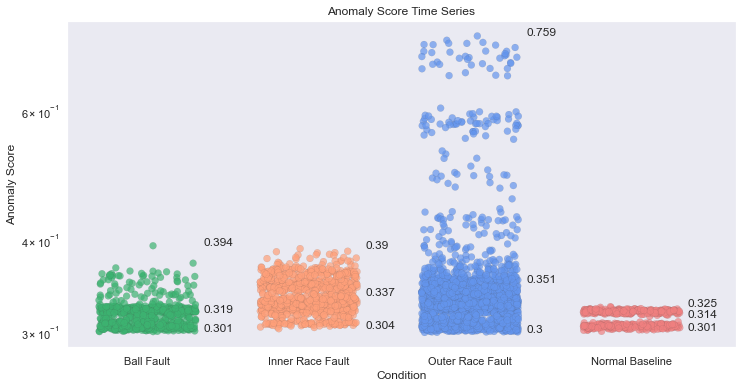

In [24]:
sns.set(rc={'figure.figsize':(12, 6)}, style = 'darkgrid')
fig, ax = plt.subplots()

jitter = 0.3
offset = 0.05

sns.stripplot(data = result, y = 'anomaly_score', x = 'condition', palette = ['mediumseagreen', 'lightsalmon', 'cornflowerblue', 'lightcoral'], alpha = 0.7, jitter = jitter,  ax = ax, linewidth = .1, size = 7)
ax.set_yscale('log')

for y, condition in enumerate(result['condition'].unique()):
    condition_results = result[result['condition'] == condition]['anomaly_score'].astype(np.float32)
    ax.text(y + jitter + offset, condition_results.max(), condition_results.max().round(3))
    ax.text(y + jitter + offset, condition_results.mean(), condition_results.mean().round(3))
    ax.text(y + jitter + offset, condition_results.min(), condition_results.min().round(3))
    
ax.set_xlim(None, y + jitter + offset + 0.3)
    
ax.set_ylabel('Anomaly Score')
ax.set_xlabel('Condition')
ax.set_title('Anomaly Score Time Series')

fig.savefig('data/results/anomaly-score_time-series.png', dpi=330, bbox_inches='tight')

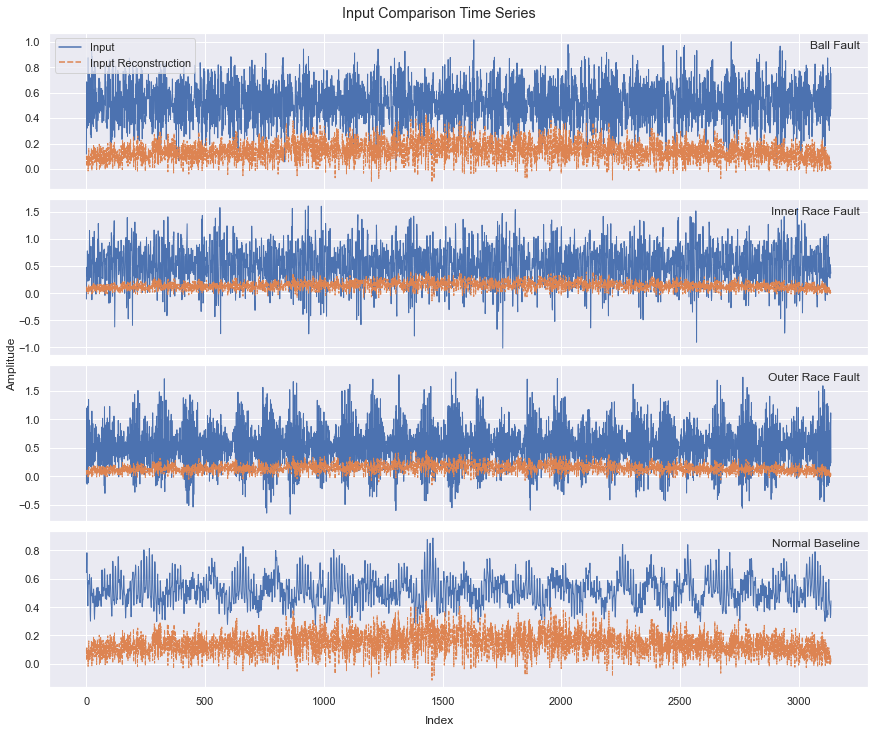

In [25]:
comparison = lineplot_comparison(result, 'Input', 'Input Reconstruction', 'Input Comparison Time Series', 'Index', 'Amplitude')
comparison.savefig('data/results/input-reconstruction_time-series.png', dpi=330, bbox_inches='tight')

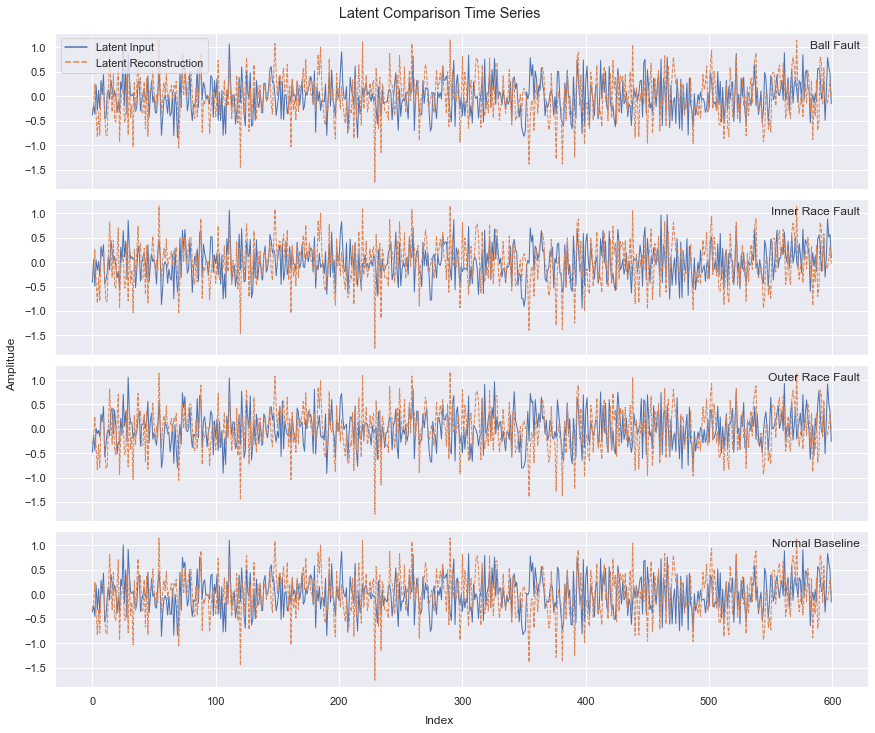

In [26]:
comparison = lineplot_comparison(result, 'Latent Input', 'Latent Reconstruction', 'Latent Comparison Time Series', 'Index', 'Amplitude')
comparison.savefig('data/results/latent-reconstruction_time-series.png', dpi=330, bbox_inches='tight')

### Stacked Time Series

In [30]:
features_test = np.array(features_test.tolist())
predictions = pipeline_stacked_time_series.predict_proba(features_test)

predictions = pd.DataFrame(predictions)
predictions = predictions.T
predictions = predictions.rename({0: 'anomaly_score', 1: 'Input', 2: 'Input Reconstruction', 3: 'Latent Input', 4: 'Latent Reconstruction'}, axis = 1)

columns_flatten = ['Input', 'Input Reconstruction', 'Latent Input', 'Latent Reconstruction']
predictions[columns_flatten] = predictions[columns_flatten].applymap(lambda array: array.flatten())


result = labels_test.reset_index(drop=True).join(predictions)
result  = result.reset_index(drop = True)


result['relativeFaultPosition'] = result['relativeFaultPosition'].fillna('not available')
result['faultDiameter'] = result['faultDiameter'].fillna(-1)

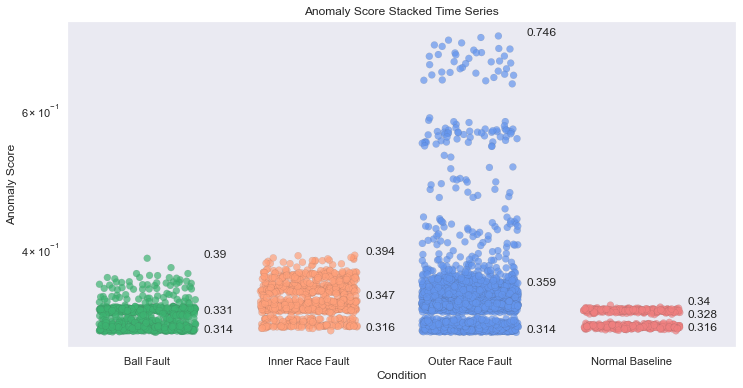

In [31]:
sns.set_style('darkgrid')

sns.set(rc={'figure.figsize':(12, 6)})
fig, ax = plt.subplots()

jitter = 0.3
offset = 0.05

sns.stripplot(data = result, y = 'anomaly_score', x = 'condition', palette = ['mediumseagreen', 'lightsalmon', 'cornflowerblue', 'lightcoral'], alpha = 0.7, jitter = jitter,  ax = ax, linewidth = .1, size = 7)
ax.set_yscale('log')

for y, condition in enumerate(result['condition'].unique()):
    condition_results = result[result['condition'] == condition]['anomaly_score'].astype(np.float32)
    ax.text(y + jitter + offset, condition_results.max(), condition_results.max().round(3))
    ax.text(y + jitter + offset, condition_results.mean(), condition_results.mean().round(3))
    ax.text(y + jitter + offset, condition_results.min(), condition_results.min().round(3))
    
ax.set_xlim(None, y + jitter + offset + 0.3)
    
ax.set_ylabel('Anomaly Score')
ax.set_xlabel('Condition')
ax.set_title('Anomaly Score Stacked Time Series')

fig.savefig('data/results/anomaly-score_stacked-time-series.png', dpi=330, bbox_inches='tight')

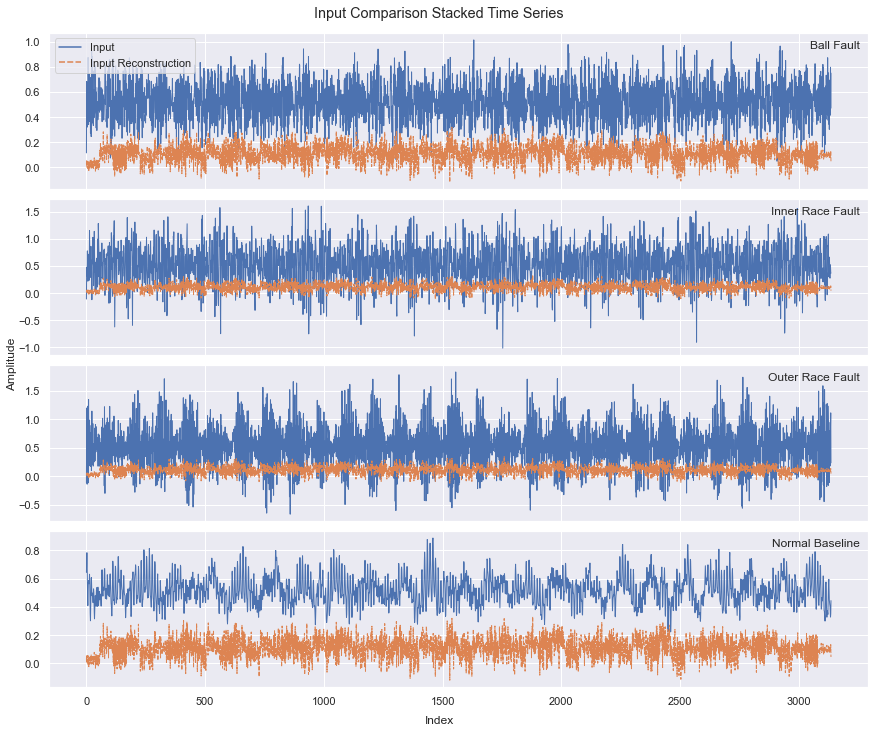

In [32]:
comparison = lineplot_comparison(result, 'Input', 'Input Reconstruction', 'Input Comparison Stacked Time Series', 'Index', 'Amplitude')
comparison.savefig('data/results/input-reconstruction_stacked-time-series.png', dpi=330, bbox_inches='tight')

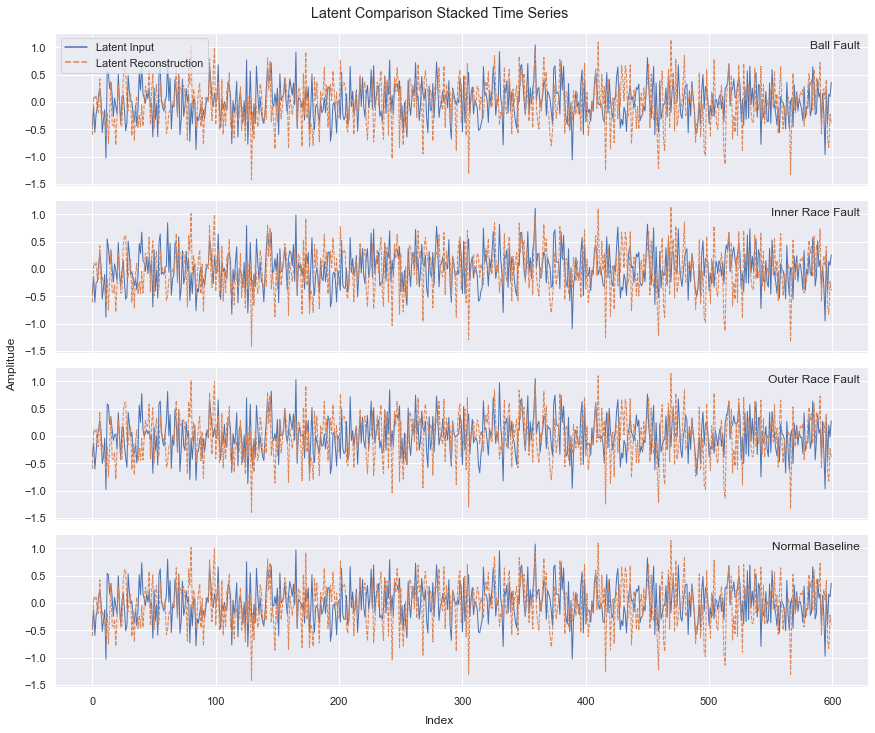

In [33]:
comparison = lineplot_comparison(result, 'Latent Input', 'Latent Reconstruction', 'Latent Comparison Stacked Time Series', 'Index', 'Amplitude')
comparison.savefig('data/results/latent-reconstruction_stacked-time-series.png', dpi=330, bbox_inches='tight')

### Frequency Spectrum

In [34]:
features_test = np.array(features_test.tolist())
predictions = pipeline_frequency_spectrum.predict_proba(features_test)

predictions = pd.DataFrame(predictions)
predictions = predictions.T
predictions = predictions.rename({0: 'anomaly_score', 1: 'Input', 2: 'Input Reconstruction', 3: 'Latent Input', 4: 'Latent Reconstruction'}, axis = 1)

columns_flatten = ['Input', 'Input Reconstruction', 'Latent Input', 'Latent Reconstruction']
predictions[columns_flatten] = predictions[columns_flatten].applymap(lambda array: array.flatten())


result = labels_test.reset_index(drop=True).join(predictions)
result  = result.reset_index(drop = True)


result['relativeFaultPosition'] = result['relativeFaultPosition'].fillna('not available')
result['faultDiameter'] = result['faultDiameter'].fillna(-1)

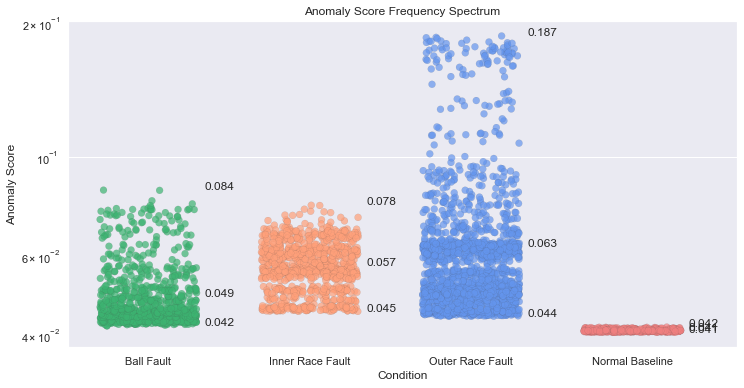

In [35]:
sns.set_style('darkgrid')

sns.set(rc={'figure.figsize':(12, 6)})
fig, ax = plt.subplots()

jitter = 0.3
offset = 0.05

sns.stripplot(data = result, y = 'anomaly_score', x = 'condition', palette = ['mediumseagreen', 'lightsalmon', 'cornflowerblue', 'lightcoral'], alpha = 0.7, jitter = jitter,  ax = ax, linewidth = .1, size = 7)
ax.set_yscale('log')

for y, condition in enumerate(result['condition'].unique()):
    condition_results = result[result['condition'] == condition]['anomaly_score'].astype(np.float32)
    ax.text(y + jitter + offset, condition_results.max(), condition_results.max().round(3))
    ax.text(y + jitter + offset, condition_results.mean(), condition_results.mean().round(3))
    ax.text(y + jitter + offset, condition_results.min(), condition_results.min().round(3))
    
ax.set_xlim(None, y + jitter + offset + 0.3)
    
ax.set_ylabel('Anomaly Score')
ax.set_xlabel('Condition')
ax.set_title('Anomaly Score Frequency Spectrum')

fig.savefig('data/results/anomaly-score_frequency-spectrum.png', dpi=330, bbox_inches='tight')

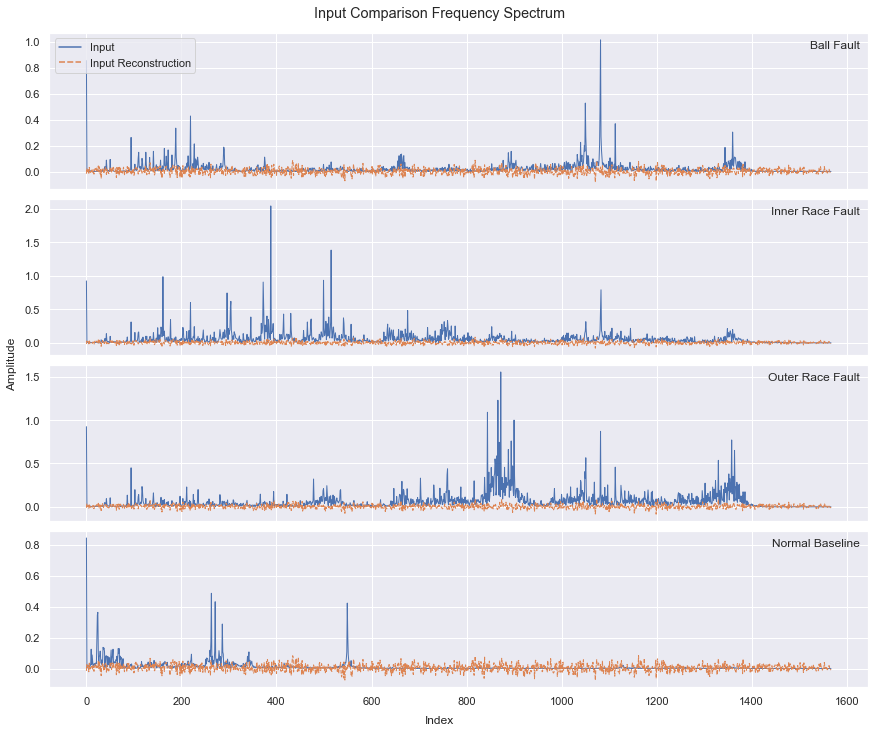

In [36]:
comparison = lineplot_comparison(result, 'Input', 'Input Reconstruction', 'Input Comparison Frequency Spectrum', 'Index', 'Amplitude')
comparison.savefig('data/results/input-reconstruction_frequency-spectrum.png', dpi=330, bbox_inches='tight')

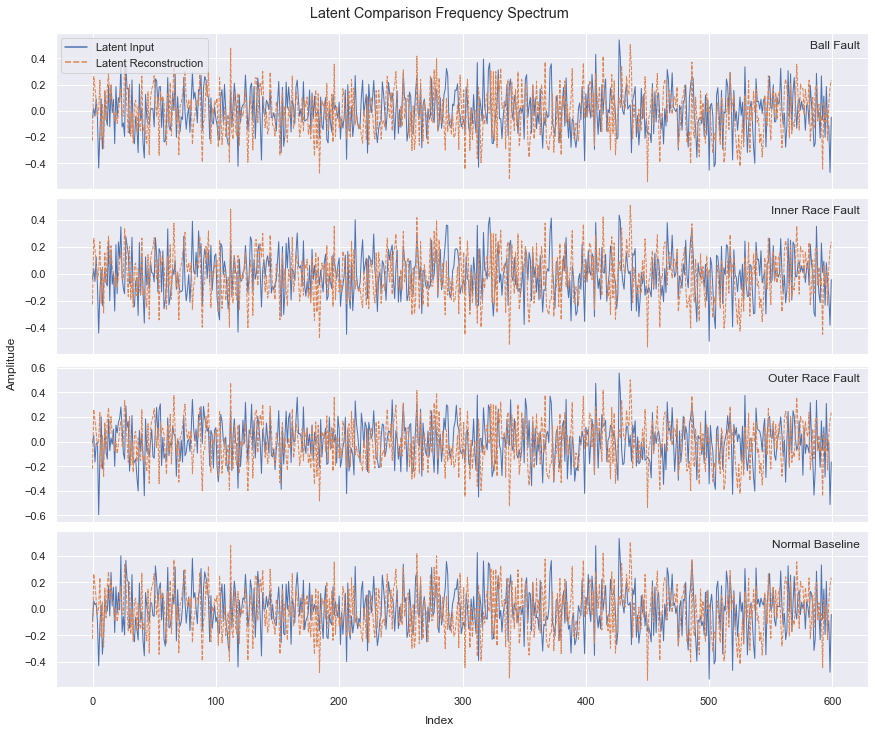

In [37]:
comparison = lineplot_comparison(result, 'Latent Input', 'Latent Reconstruction', 'Latent Comparison Frequency Spectrum', 'Index', 'Amplitude')
comparison.savefig('data/results/latent-reconstruction_frequency-spectrum.png', dpi=330, bbox_inches='tight')

### Spectrogram

In [38]:
features_test = np.array(features_test.tolist())
predictions = pipeline_spectrogram.predict_proba(features_test)

predictions = pd.DataFrame(predictions)
predictions = predictions.T
predictions = predictions.rename({0: 'anomaly_score', 1: 'Input', 2: 'Input Reconstruction', 3: 'Latent Input', 4: 'Latent Reconstruction'}, axis = 1)

columns_flatten = ['Input', 'Input Reconstruction', 'Latent Input', 'Latent Reconstruction']
predictions[columns_flatten] = predictions[columns_flatten].applymap(lambda array: array.flatten())


result = labels_test.reset_index(drop=True).join(predictions)
result  = result.reset_index(drop = True)


result['relativeFaultPosition'] = result['relativeFaultPosition'].fillna('not available')
result['faultDiameter'] = result['faultDiameter'].fillna(-1)

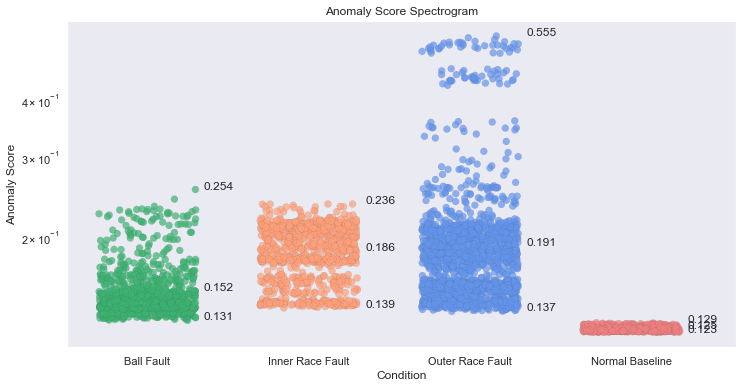

In [39]:
sns.set_style('darkgrid')

sns.set(rc={'figure.figsize':(12, 6)})
fig, ax = plt.subplots()

jitter = 0.3
offset = 0.05

sns.stripplot(data = result, y = 'anomaly_score', x = 'condition', palette = ['mediumseagreen', 'lightsalmon', 'cornflowerblue', 'lightcoral'], alpha = 0.7, jitter = jitter,  ax = ax, linewidth = .1, size = 7)
ax.set_yscale('log')

for y, condition in enumerate(result['condition'].unique()):
    condition_results = result[result['condition'] == condition]['anomaly_score'].astype(np.float32)
    ax.text(y + jitter + offset, condition_results.max(), condition_results.max().round(3))
    ax.text(y + jitter + offset, condition_results.mean(), condition_results.mean().round(3))
    ax.text(y + jitter + offset, condition_results.min(), condition_results.min().round(3))
    
ax.set_xlim(None, y + jitter + offset + 0.3)
    
ax.set_ylabel('Anomaly Score')
ax.set_xlabel('Condition')
ax.set_title('Anomaly Score Spectrogram')

fig.savefig('data/results/anomaly-score_spectrogram.png', dpi=330, bbox_inches='tight')

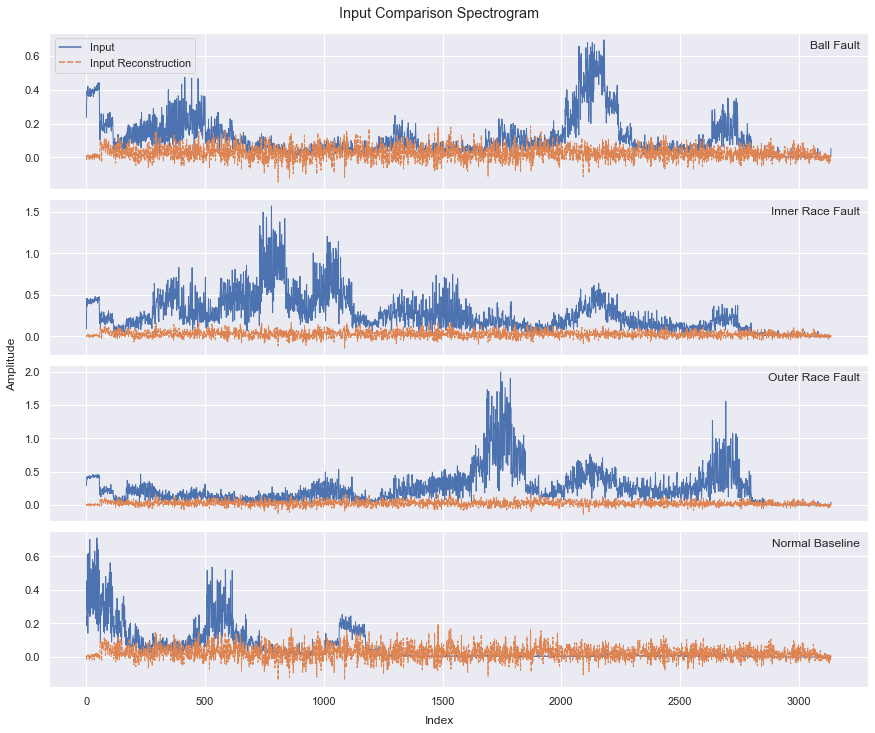

In [40]:
comparison = lineplot_comparison(result, 'Input', 'Input Reconstruction', 'Input Comparison Spectrogram', 'Index', 'Amplitude')
comparison.savefig('data/results/input-reconstruction_spectrogram.png', dpi=330, bbox_inches='tight')

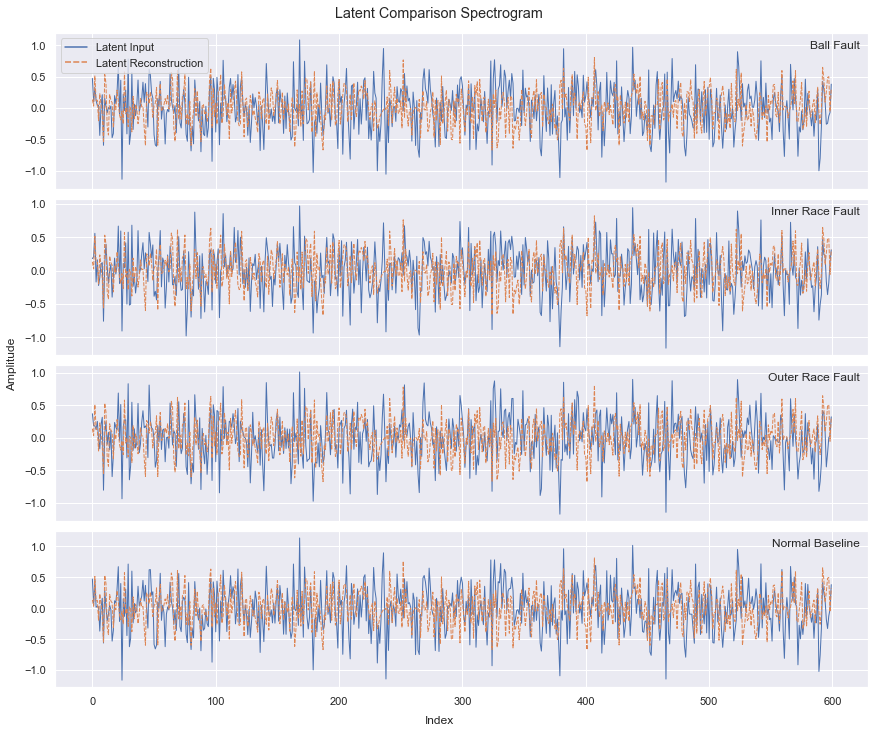

In [41]:
comparison = lineplot_comparison(result, 'Latent Input', 'Latent Reconstruction', 'Latent Comparison Spectrogram', 'Index', 'Amplitude')
comparison.savefig('data/results/latent-reconstruction_spectrogram.png', dpi=330, bbox_inches='tight')

### Feature Extraction

In [42]:
features_test = np.array(features_test.tolist())
predictions = pipeline_feature_extraction.predict_proba(features_test)

predictions = pd.DataFrame(predictions)
predictions = predictions.T
predictions = predictions.rename({0: 'anomaly_score', 1: 'Input', 2: 'Input Reconstruction', 3: 'Latent Input', 4: 'Latent Reconstruction'}, axis = 1)

columns_flatten = ['Input', 'Input Reconstruction', 'Latent Input', 'Latent Reconstruction']
predictions[columns_flatten] = predictions[columns_flatten].applymap(lambda array: array.flatten())


result = labels_test.reset_index(drop=True).join(predictions)
result  = result.reset_index(drop = True)


result['relativeFaultPosition'] = result['relativeFaultPosition'].fillna('not available')
result['faultDiameter'] = result['faultDiameter'].fillna(-1)

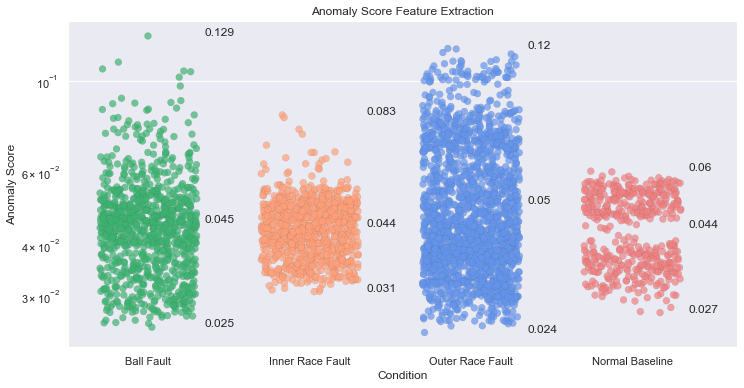

In [43]:
sns.set_style('darkgrid')

sns.set(rc={'figure.figsize':(12, 6)})
fig, ax = plt.subplots()

jitter = 0.3
offset = 0.05

sns.stripplot(data = result, y = 'anomaly_score', x = 'condition', palette = ['mediumseagreen', 'lightsalmon', 'cornflowerblue', 'lightcoral'], alpha = 0.7, jitter = jitter,  ax = ax, linewidth = .1, size = 7)
ax.set_yscale('log')

for y, condition in enumerate(result['condition'].unique()):
    condition_results = result[result['condition'] == condition]['anomaly_score'].astype(np.float32)
    ax.text(y + jitter + offset, condition_results.max(), condition_results.max().round(3))
    ax.text(y + jitter + offset, condition_results.mean(), condition_results.mean().round(3))
    ax.text(y + jitter + offset, condition_results.min(), condition_results.min().round(3))
    
ax.set_xlim(None, y + jitter + offset + 0.3)
    
ax.set_ylabel('Anomaly Score')
ax.set_xlabel('Condition')
ax.set_title('Anomaly Score Feature Extraction')

fig.savefig('data/results/anomaly-score_feature-extraction.png', dpi=330, bbox_inches='tight')

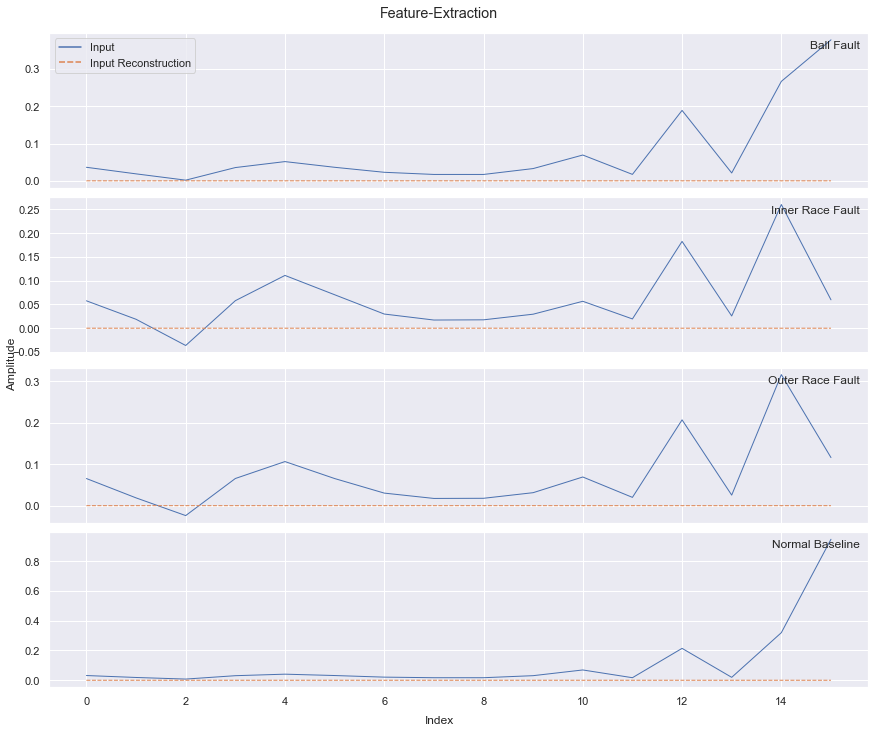

In [44]:
comparison = lineplot_comparison(result, 'Input', 'Input Reconstruction', 'Feature-Extraction', 'Index', 'Amplitude')
comparison.savefig('data/results/input-reconstruction_feature-extraction.png', dpi=330, bbox_inches='tight')

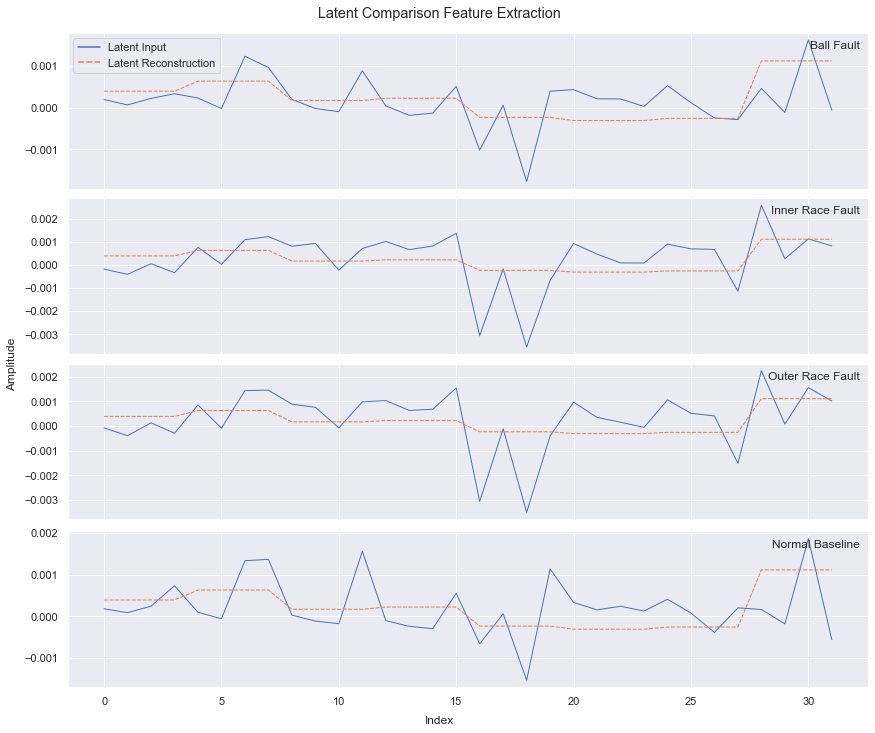

In [45]:
comparison = lineplot_comparison(result, 'Latent Input', 'Latent Reconstruction', 'Latent Comparison Feature Extraction', 'Index', 'Amplitude')
comparison.savefig('data/results/latent-reconstruction_feature-extraction.png', dpi=330, bbox_inches='tight')